# Predicting Credit Card Frauds

### Credit card fraud is one of the biggest economic crimes with global scale. On one hand the credit card companies want to promote ease of use of such cards. And at the same such ease of use can create challenges related to security and trust of credit card transactions. Therefore,  having a mathematical algorithm that can predict such fraud and detect them correctly is of big values to both financial institutions and consumers. 

### Here we are working a dataset containing transactions made by group of credit card holders in September 2013 over a span of two days. There are 284,807 transactions with only 492 frauds, meaning the dataset is highly unbalanced. The positive class (frauds) account for 0.172% of all transactions.

### The dataset contains numerical input variables that are the result of a PCA transformation. Due to confidentiality issues, the original features and more background information about the data are not shown. There are 28 features, namely V1, V2, ...V27, which are principal components obtained using PCA, except for the Time and Amount features. The Class feature is the response variable and it takes the value 1 in a case of fraud and 0 otherwise.

### There are two additional features, Time and Amount. The Time column signifies the time in seconds between each transaction and the first transaction, whereas the Amount column signifies how much money was transferred in this transaction. 

### Source: https://www.kaggle.com/mlg-ulb/creditcardfraud/version/3

<h7> Shahab Athari, leading Advisor for Control and Economic Analysis in Equinor.com located in Houston, Texas.</h7> 

In [251]:
#Import Python libraries that will be used in this model
%matplotlib inline
from IPython.display import Image
from scipy.stats import randint as sp_randint
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing, decomposition
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA as sklearn_pca
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.grid_search import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split,cross_val_score, KFold, cross_val_predict
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import random
import scipy
import seaborn as sns
import sklearn
import sklearn.cross_validation 
import sklearn.tree
import time
import timeit
import warnings 
warnings.simplefilter('ignore')

In [252]:
# Load the data
path1 = ("C:/Users/aath/Dropbox/MAEN/DS/data/Kaggle/cc/creditcard.csv")
n = sum(1 for line in open(path1)) - 1 #number of records in file (excludes header)
s = 284807 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
df = pd.read_csv(path1, skiprows=skip)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [253]:
# Check the timespan of the data 
print("Total time spanning: {:.1f} days".format(df['Time'].max() / (3600 * 24.0)))

Total time spanning: 2.0 days


In [254]:
# Check the percentage fraud cases
print("{:.3f} % of all transactions are fraud. ".format(np.sum(df['Class']) / df.shape[0] * 100))

0.173 % of all transactions are fraud. 


We can see that the feature space is very imbalance and fraud cases are very rare. Becasue of this we should be very careful about our learner selection as the risk of overfitting is very high.

(0, 50000)

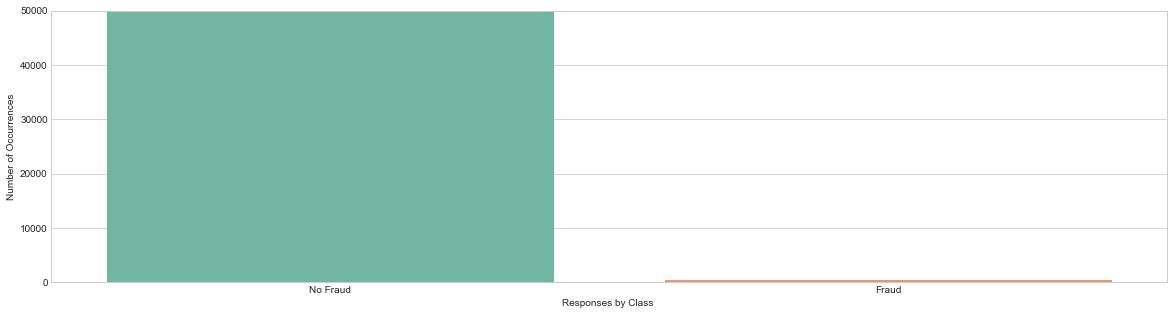

In [255]:
# To show the imbalance in first 50,000 data
plt.figure(figsize=(20, 5))
sns.set_style("whitegrid")
plt.subplot(1, 1, 1)
ax = sns.countplot(x="Class", data=df, palette="Set2")
ax.set_xlabel('Responses by Class ')
ax.set_ylabel('Number of Occurrences')
ax.set_xticklabels(['No Fraud','Fraud'], fontsize=10)
plt.ylim(0, 50000)

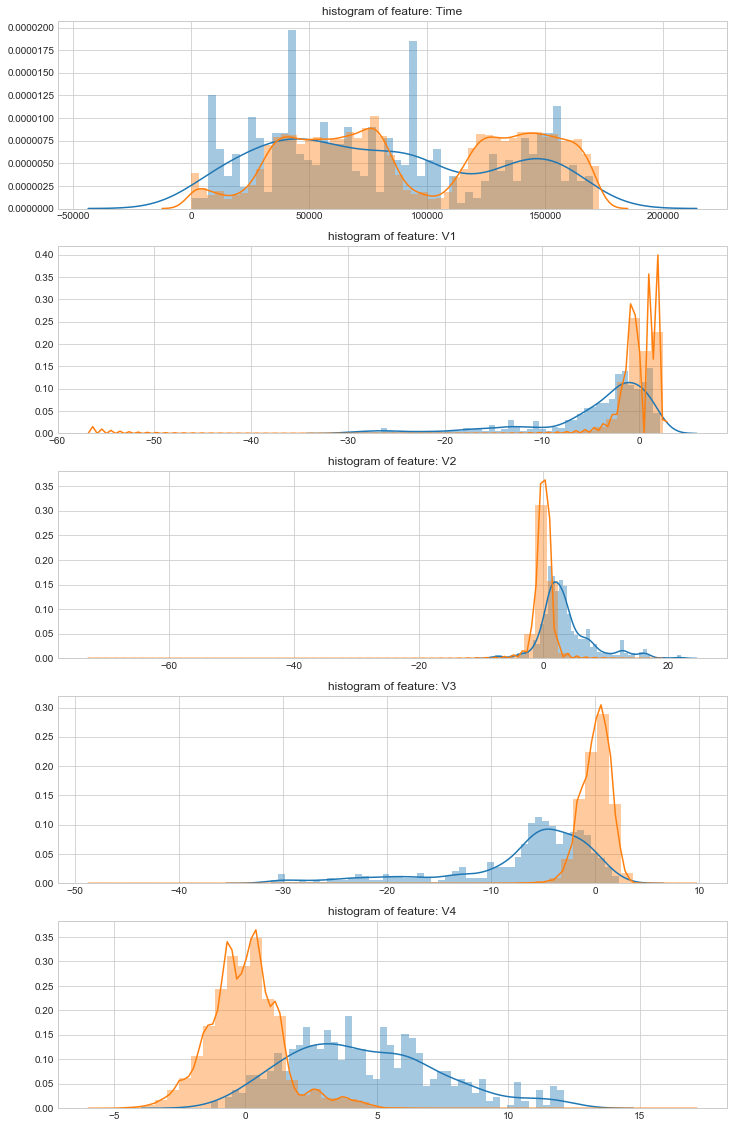

In [256]:
# let's draw the histogram for first five features:

import matplotlib.gridspec as gridspec
plt.figure(figsize=(12,5*4))
gs = gridspec.GridSpec(5, 1)
for i, cn in enumerate(df.columns[:5]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

# Above code will raise a warning related to deprecated function. And to avoid seeing this warning
# we suppress it using: 
warnings.simplefilter('ignore')

Histograms of 5 features are highly skewed. In addition, the dataset does not have many features, so trimming the tails would lose important information. 

## Dealing with class imbalance

Class imbalance can negatively influence both the evaluation of learning algorithms and also the learning process during the fitting stage. For machine learning algorithms we typically optimize a reward or cost function that is computed as a sum over the training examples that it sees during fitting. Because of this the decision rule is likely going to be biased towards the majority class.

One way to address this is to assign a larger penalty to wrong predictions on the minority class. Alternatively, we can include up-sampling the minority class, down-sampling the majority class or generate synthetic training samples. Unfortunately, there's no universally best solution, no technique that works best across different problem domains. In this case we will use the up-sampling of the Fraud case.

In [257]:
# Create a separate table for each class
df_minority = df[df.Class == 1]
df_majority = df[df.Class == 0]

# Determine the  size of minority class
minority_size = len(df[df['Class'] == 1])
majority_size = len(df[df['Class'] == 0])

# Upsample the minority case
minority_upsampled = resample(df_minority, replace=True, n_samples=majority_size, random_state=140)

# Combine in a new dataframe 'data' the majority class with the upsampled minority class
balanced_df = pd.concat([df_majority,minority_upsampled])
 
# Display new class counts
balanced_df.Class.value_counts()

1    284315
0    284315
Name: Class, dtype: int64

In [258]:
# Because of high computational cost we will use only a random sample 
# from previous balanced dataset for further analysis
small_sample_size = 5000
small_balanced_df=balanced_df.sample(small_sample_size, random_state=2)

In [259]:
# Setup a new dataframe that contains the features per Class, dropping the time
features_only = small_balanced_df.drop(['Time'],axis = 1)

In [260]:
#Describe the data using statistics
features_only.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,-2.318860,1.783304,-3.440448,2.221222,-1.476152,-0.703147,-2.700969,0.221923,-1.254657,-2.780209,...,0.358461,0.012078,-0.020831,-0.057972,0.021856,0.022352,0.072537,0.050614,101.432320,0.50320
std,5.392736,3.658162,6.042524,3.150781,4.095901,1.726737,5.710548,4.779670,2.264012,4.441288,...,2.793921,1.170810,1.174285,0.560350,0.661550,0.475312,1.020684,0.489498,233.258778,0.50004
min,-30.552380,-17.665157,-31.103685,-4.591328,-22.105532,-8.361075,-43.557242,-41.044261,-13.434066,-24.588262,...,-22.797604,-8.887017,-19.254328,-2.417821,-4.781606,-1.333728,-9.543518,-3.541725,0.000000,0.00000
25%,-2.890415,-0.145332,-5.076070,-0.105266,-1.730411,-1.585726,-3.029283,-0.211865,-2.270235,-4.565254,...,-0.164320,-0.531496,-0.235697,-0.414792,-0.315404,-0.289581,-0.067850,-0.057939,1.180000,0.00000
50%,-0.793155,0.982064,-1.432900,1.309464,-0.416196,-0.681215,-0.662931,0.158183,-0.707031,-0.871105,...,0.152954,0.033922,-0.032207,-0.006809,0.051042,-0.010091,0.047265,0.035411,17.875000,1.00000
75%,1.053076,2.812312,0.280369,4.194211,0.480019,0.078746,0.256406,0.833441,0.169550,0.013534,...,0.641594,0.579124,0.199119,0.359807,0.388361,0.330020,0.454851,0.223191,99.990000,1.00000
max,2.409347,22.057729,3.406873,12.114672,12.277363,7.679027,8.467181,20.007208,5.923534,9.594453,...,27.202839,8.361985,5.756271,3.054049,2.208209,2.745261,3.052358,15.870474,4476.720000,1.00000


Above table reconfirmed that the distributions for each feature is highly skewed.
We also can see that scale of each feature differs and this can cause suboptimal learning especially when using classification method. Therefore, to improve the predictive accuracy, we will scale the data using a Standard Normal Distribution N(0,1):

In [261]:
names = features_only.columns # Create the headings only of the dataframe
names = names[:-1] # drop last column of the table

In [262]:
# Standardize the feature set
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_only[names] = scaler.fit_transform(features_only[names])
scaled_features_only = features_only # Scaled features

Do we have any similarities between the features? Let's visually inspect the correlation matrix between the features.

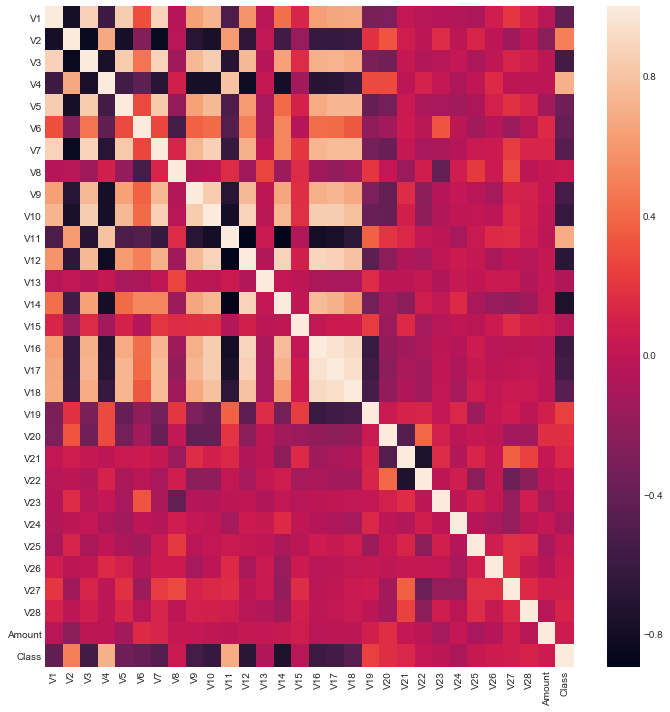

In [263]:
features_only_scaled = features_only # Create a copy of features

correlation_mat = scaled_features_only.corr() 
#Plot heatmap
plt.figure(figsize=(10, 10))
ax = sns.heatmap(correlation_mat)  # use this if want text added to each box annot=True
plt.tight_layout()
plt.show()

Almost all of the features are not similar to one another, meaning our dataset is fairly diverse. This is yet another confirmation that we should keep all our feature space.

### Model Selection ###

We split the dataset 80/20 between train and test parts. We will train and fit multiple models using the training set and do evaluation of their predictive power using the test data. Splitting the dateset is the critical strategy for reducing the risk of overfitting.

We also tune the hyperparameters of all models to improve their prediction powers. And confusion matrix to demonstrate characteristics such as accuracy, sensitivity/recall, specificity, false positive rate and precision.

As the purpose of the analysis is to predict the rare cases of fraud we will focus on sensitivity or recall as the main evaluation metric. Also, false negative in this case are more important as false positives (normal transactions that are marked as possible fraud) are more acceptable than false negatives where actual fraud has happened and we fail to detect. 

We tested following models:

  - Logistic Regression
  - Decision Tree
  - Random Forest
  - Naive - Bayes (Bernoulli)
  - KNeighbors Classifier
  - Support Vector Machine
  - Gradient Boosting Classifier

Both classes of no fraud or fraud are labled as 0 and 1.

### Training and testing set preparation
Priot to model selection we need to split the data into training, development and test set. We are using first 80% of the data as the training and validation set. The remaining 20% will be used as the testing set:

NameError: name 'df_pca_sample' is not defined

In [264]:
TEST_RATIO = 0.20
#scaled_features_only.sort_values('Time', inplace = True)
TRA_INDEX = int((1-TEST_RATIO) * scaled_features_only.shape[0])
train_x = scaled_features_only.iloc[:TRA_INDEX, 1:-2].values
train_y = scaled_features_only.iloc[:TRA_INDEX, -1].values
test_x = scaled_features_only.iloc[TRA_INDEX:, 1:-2].values
test_y = scaled_features_only.iloc[TRA_INDEX:, -1].values

# Number of cross validation used for all models
CF_no = 5

## Model Training: Logistic Regression

In [265]:
#Start the timer as a measure of the computing effort
start_time = time.time()

# Check any overfitting problem using Cross Fold validation
log_reg = sklearn.linear_model.LogisticRegression()
score = sklearn.cross_validation.cross_val_score(log_reg, train_x, train_y, cv=CF_no)
print(score)

[0.94 0.93 0.92 0.93 0.94]


In [266]:
#Tune parameters
# C parameter
c_param = [0.1,0.5,1, 2, 5, 10]

#Tune the type of penalty used between l1 and l2
penalty_type = ['l1','l2']
parameters = {'C': c_param, 'penalty': penalty_type}

#Fit parameters
%timeit  
log_reg_tuned = GridSearchCV(log_reg, param_grid=parameters, cv=CF_no)

#Fit the tunned classifier in the traiing space
log_reg_tuned.fit(train_x, train_y)

#Print the best parameters
print(log_reg_tuned.best_params_)

#Print the time required to fit and evaluate the model
print("--- %s seconds ---" % round((time.time() - start_time)))

{'C': 10, 'penalty': 'l1'}
--- 65 seconds ---


In [304]:
# Check the prediction power of the model
pred_y = np.array(log_reg_tuned.predict(test_x))
true_y = np.array(test_y)

### Evaluating the model
Below we will use the confusion matrix which is a way of tabulating the number of misclassifications. Also, we can see the number of predicted classes which were categorized wrongly as true. But before that we need to set up a function that also plots the outcome of this matrix.

In [268]:
# A function to create confusion matrix. Part 1 of 2
# This is part 1 that can be used for all models. Part 2 depends on model specific data

import itertools  
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[502  12]
 [ 36 450]]


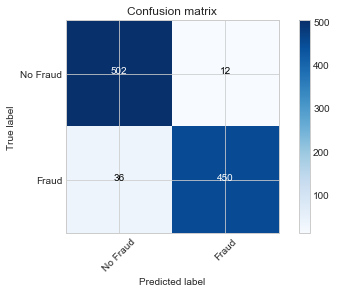

In [269]:
# A function to create confusion matrix. Part 2 of 2
class_names = ['No Fraud', 'Fraud']
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(true_y, pred_y)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()
# First argument is true values, second argument is predicted values producing a 2x2 matrix

In [270]:
target_names = ['No Fraud', 'Fraud']
print(classification_report(true_y, pred_y, target_names=target_names))

             precision    recall  f1-score   support

   No Fraud       0.93      0.98      0.95       514
      Fraud       0.97      0.93      0.95       486

avg / total       0.95      0.95      0.95      1000



In [271]:
# Metrics computed from a confusion matrix
TP = cnf_matrix[1, 1]
TN = cnf_matrix[0, 0]
FP = cnf_matrix[0, 1]
FN = cnf_matrix[1, 0]

print("True Positives (TP): We correctly predicted the fraud: {}. ".format(TP))
print("True Negatives (TN): we correctly predicted that no fraud: {}. ".format(TN))
print("False Positives (FP): we incorrectly predicted that it is a fraud or Type I error: {}. ".format(FP))
print("False Negatives (FN): we incorrectly predicted that it is not a fraud or Type II error: {}. ".format(FN))

print("===================================================")

print("Overall, how often is the classifier correct (accuracy)? {}. ".format((TP + TN) / float(TP + TN + FP + FN)))      
print("Overall, how often is the classifier incorrect? {}. ".format((FP + FN) / float(TP + TN + FP + FN))) 
print("When the actual value is positive, how often is the prediction correct (sensitivity or recall)? {}.".format(TP / float(FN + TP))) 
print("When the actual value is negative, how often is the prediction correct (specificity)? {}.".format(TN / (TN + FP))) 
print("When the actual value is negative, how often is the prediction incorrect (false positive rate)? {}.".format(FP / float(TN + FP))) 
print("When a positive value is predicted, how often is the prediction correct (precision)? {}.".format(TP / float(TP + FP))) 

True Positives (TP): We correctly predicted the fraud: 450. 
True Negatives (TN): we correctly predicted that no fraud: 502. 
False Positives (FP): we incorrectly predicted that it is a fraud or Type I error: 12. 
False Negatives (FN): we incorrectly predicted that it is not a fraud or Type II error: 36. 
Overall, how often is the classifier correct (accuracy)? 0.952. 
Overall, how often is the classifier incorrect? 0.048. 
When the actual value is positive, how often is the prediction correct (sensitivity or recall)? 0.9259259259259259.
When the actual value is negative, how often is the prediction correct (specificity)? 0.9766536964980544.
When the actual value is negative, how often is the prediction incorrect (false positive rate)? 0.023346303501945526.
When a positive value is predicted, how often is the prediction correct (precision)? 0.974025974025974.


Next, we will try a different model to see if we can reduce this error.

## Model Training: Decision Tree

In [272]:
#Start the timer as a measure of the computing effort
start_time = time.time()

D_tree = DecisionTreeClassifier(random_state=37)
score = sklearn.cross_validation.cross_val_score(D_tree, train_x, train_y, cv=CF_no)
print(score)

[0.98 0.98 0.97 0.98 0.98]


In [305]:
D_tree = DecisionTreeClassifier(random_state=37)
params = {"max_depth": [2, 5, 10, 15], "min_samples_leaf": sp_randint(1, 5), 
          "criterion": ["gini", "entropy"]}

D_tree_tuned = RandomizedSearchCV(D_tree, params)
D_tree_tuned.fit(train_x,train_y)

#Print the best parameters
print(D_tree_tuned.best_params_)  

#Print the time required to fit and evaluate the model
print("--- %s seconds ---" % round((time.time() - start_time)))

{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1}
--- 50767 seconds ---


In [306]:
# Using the best parameters but choose a shallower tree 
# in an indivisual classifier to reduce the risk of overfitting
decision_tree = tree.DecisionTreeClassifier(
    criterion='gini',
    min_samples_leaf= 1,
    max_depth=3,
    random_state = 1337
)
score = sklearn.cross_validation.cross_val_score(D_tree, train_x, train_y, cv=CF_no)
print(score)

decision_tree.fit(train_x,train_y)

[0.98 0.98 0.97 0.98 0.98]


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1337,
            splitter='best')

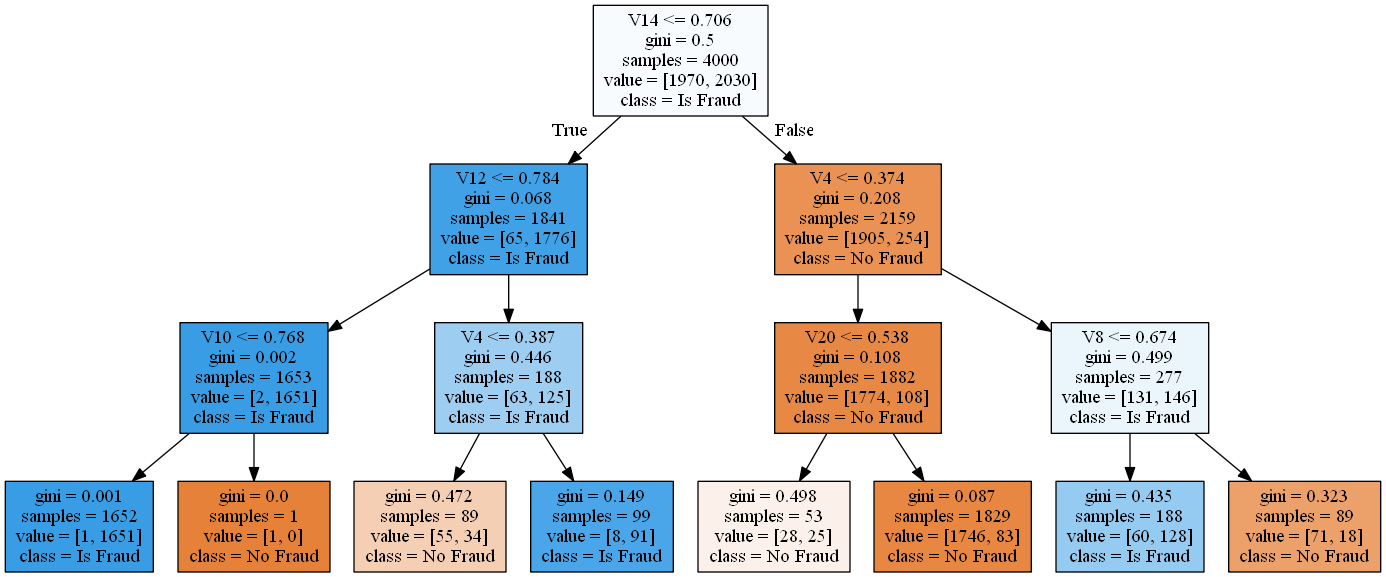

In [275]:
names = scaled_features_only.iloc[:TRA_INDEX, 1:-2].columns # Names of X features 

# Render the decision tree
dot_data = tree.export_graphviz(decision_tree, out_file=None, feature_names = names, 
    class_names = ['No Fraud', 'Is Fraud'],
    filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [276]:
# Check the prediction power of the model
pred_y = np.array(D_tree_tuned.predict(test_x))
true_y = np.array(test_y)

Confusion matrix, without normalization
[[494  20]
 [  1 485]]


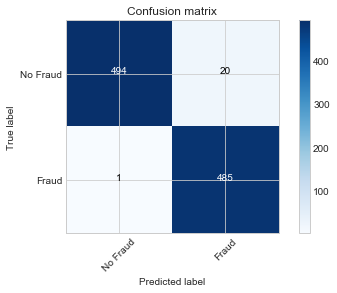

In [277]:
class_names = ['No Fraud', 'Fraud']
np.set_printoptions(precision=2)

cnf_matrix = confusion_matrix(true_y, pred_y)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Confusion matrix')
plt.show()

In [278]:
target_names = ['No Fraud', 'Fraud']
print(classification_report(true_y, pred_y, target_names=target_names))

             precision    recall  f1-score   support

   No Fraud       1.00      0.96      0.98       514
      Fraud       0.96      1.00      0.98       486

avg / total       0.98      0.98      0.98      1000



In [279]:
# Metrics computed from a confusion matrix
TP = cnf_matrix[1, 1]
TN = cnf_matrix[0, 0]
FP = cnf_matrix[0, 1]
FN = cnf_matrix[1, 0]

print("True Positives (TP): We correctly predicted the fraud: {}. ".format(TP))
print("True Negatives (TN): we correctly predicted that no fraud: {}. ".format(TN))
print("False Positives (FP): we incorrectly predicted that it is a fraud or Type I error: {}. ".format(FP))
print("False Negatives (FN): we incorrectly predicted that it is not a fraud or Type II error: {}. ".format(FN))

print("===================================================")

print("Overall, how often is the classifier correct (accuracy)? {}. ".format((TP + TN) / float(TP + TN + FP + FN)))      
print("Overall, how often is the classifier incorrect? {}. ".format((FP + FN) / float(TP + TN + FP + FN))) 
print("When the actual value is positive, how often is the prediction correct (sensitivity or recall)? {}.".format(TP / float(FN + TP))) 
print("When the actual value is negative, how often is the prediction correct (specificity)? {}.".format(TN / (TN + FP))) 
print("When the actual value is negative, how often is the prediction incorrect (false positive rate)? {}.".format(FP / float(TN + FP))) 
print("When a positive value is predicted, how often is the prediction correct (precision)? {}.".format(TP / float(TP + FP))) 

True Positives (TP): We correctly predicted the fraud: 485. 
True Negatives (TN): we correctly predicted that no fraud: 494. 
False Positives (FP): we incorrectly predicted that it is a fraud or Type I error: 20. 
False Negatives (FN): we incorrectly predicted that it is not a fraud or Type II error: 1. 
Overall, how often is the classifier correct (accuracy)? 0.979. 
Overall, how often is the classifier incorrect? 0.021. 
When the actual value is positive, how often is the prediction correct (sensitivity or recall)? 0.9979423868312757.
When the actual value is negative, how often is the prediction correct (specificity)? 0.9610894941634242.
When the actual value is negative, how often is the prediction incorrect (false positive rate)? 0.038910505836575876.
When a positive value is predicted, how often is the prediction correct (precision)? 0.9603960396039604.


## Model Training: Random Forest

In [280]:
#Start the timer as a measure of the computing effort
start_time = time.time()

Random_f = ensemble.RandomForestClassifier(n_estimators=20, max_depth=5)

# Fold Cross validation
score = sklearn.cross_validation.cross_val_score(Random_f, train_x, train_y, cv=CF_no)

# Fold Cross validation
print("Scores of cross fold validation: {}".format(score), " by {} number of foldings ".format(CF_no))

Scores of cross fold validation: [0.96 0.96 0.95 0.96 0.97]  by 5 number of foldings 


In [281]:
Random_f.fit(train_x, train_y)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=5,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
print(Random_f.feature_importances_)

#Print the time required to fit and evaluate the model
print("--- %s seconds ---" % round((time.time() - start_time)))

[0.03 0.06 0.16 0.   0.   0.06 0.01 0.   0.11 0.09 0.05 0.   0.26 0.
 0.05 0.06 0.01 0.   0.01 0.   0.   0.   0.   0.   0.   0.01 0.  ]
--- 1 seconds ---


In [282]:
# Check the prediction power of the model
pred_y = np.array(Random_f.predict(test_x))
true_y = np.array(test_y)

Confusion matrix, without normalization
[[510   4]
 [ 33 453]]


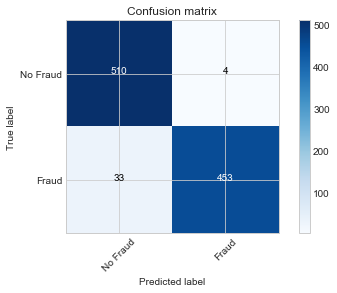

In [283]:
class_names = ['No Fraud', 'Fraud']
np.set_printoptions(precision=2)

cnf_matrix = confusion_matrix(true_y, pred_y)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Confusion matrix')
plt.show()

In [284]:
# Metrics computed from a confusion matrix
TP = cnf_matrix[1, 1]
TN = cnf_matrix[0, 0]
FP = cnf_matrix[0, 1]
FN = cnf_matrix[1, 0]

print("True Positives (TP): We correctly predicted the fraud: {}. ".format(TP))
print("True Negatives (TN): we correctly predicted that no fraud: {}. ".format(TN))
print("False Positives (FP): we incorrectly predicted that it is a fraud or Type I error: {}. ".format(FP))
print("False Negatives (FN): we incorrectly predicted that it is not a fraud or Type II error: {}. ".format(FN))

print("===================================================")

print("Overall, how often is the classifier correct (accuracy)? {}. ".format((TP + TN) / float(TP + TN + FP + FN)))      
print("Overall, how often is the classifier incorrect? {}. ".format((FP + FN) / float(TP + TN + FP + FN))) 
print("When the actual value is positive, how often is the prediction correct (sensitivity or recall)? {}.".format(TP / float(FN + TP))) 
print("When the actual value is negative, how often is the prediction correct (specificity)? {}.".format(TN / (TN + FP))) 
print("When the actual value is negative, how often is the prediction incorrect (false positive rate)? {}.".format(FP / float(TN + FP))) 
print("When a positive value is predicted, how often is the prediction correct (precision)? {}.".format(TP / float(TP + FP))) 

True Positives (TP): We correctly predicted the fraud: 453. 
True Negatives (TN): we correctly predicted that no fraud: 510. 
False Positives (FP): we incorrectly predicted that it is a fraud or Type I error: 4. 
False Negatives (FN): we incorrectly predicted that it is not a fraud or Type II error: 33. 
Overall, how often is the classifier correct (accuracy)? 0.963. 
Overall, how often is the classifier incorrect? 0.037. 
When the actual value is positive, how often is the prediction correct (sensitivity or recall)? 0.9320987654320988.
When the actual value is negative, how often is the prediction correct (specificity)? 0.9922178988326849.
When the actual value is negative, how often is the prediction incorrect (false positive rate)? 0.007782101167315175.
When a positive value is predicted, how often is the prediction correct (precision)? 0.9912472647702407.


In [285]:
# Which metrics should you focus on?
# This is the case of fraud detection therefore we should optimize for sensitivity or recall:
# FN is in this case more important as false positives (normal transactions that are marked as possible fraud
# are more acceptable than false negatives where actual fraud has happened and we fail to detect

We try another model.

## Model Training: Naive Bayes

In [286]:
# Prepare dataframe tables
X = scaled_features_only.iloc[:, 1:-2].values
y = scaled_features_only.iloc[:, -1].values

In [287]:
X_train = scaled_features_only.iloc[:TRA_INDEX, 1:-2].values
y_train = scaled_features_only.iloc[:TRA_INDEX, -1].values
X_test = scaled_features_only.iloc[TRA_INDEX:, 1:-2].values
y_test = scaled_features_only.iloc[TRA_INDEX:, -1].values

In this classification exercise we are also interested in the associated probabilities. These probabilities give us a some kind of confidence on the prediction. However, not all classifiers provide well-calibrated probabilities, some being over-confident while others being under-confident. Thus, a separate calibration of predicted probabilities is often desirable as a postprocessing. Below we use different calibration methods to evaluate the quality of the returned probabilities using Brier’s score.

In [288]:
# Use the Brier score which measures the accuracy of probabilistic predictions. 
# It is applicable to tasks in which predictions must assign probabilities to a set of mutually 
# exclusive discrete outcomes.”
# This function returns a score of the mean square difference between 
# the actual outcome and the predicted probability of the possible outcome. 
# The actual outcome has to be 1 or 0 (true or false), while the predicted probability of the actual 
# outcome can be a value between 0 and 1.

# The brier score loss is also between 0 to 1 and the lower the score (the mean square difference is smaller), 
# the more accurate the prediction is. 
# It can be thought of as a measure of the “calibration” of a set of probabilistic predictions.

#Start the timer as a measure of the computing effort
start_time = time.time()

# Gaussian Naive-Bayes with no calibration
clf = GaussianNB()
clf.fit(X_train, y_train)  # GaussianNB itself does not support sample-weights
prob_pos_clf = clf.predict_proba(X_test)[:, 1]

# Gaussian Naive-Bayes with isotonic calibration
clf_isotonic = CalibratedClassifierCV(clf, cv=CF_no, method='isotonic')
clf_isotonic.fit(X_train, y_train) #, sw_train)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

# Gaussian Naive-Bayes with sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(clf, cv=CF_no, method='sigmoid')
clf_sigmoid.fit(X_train, y_train) #, sw_train)
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]

print("Brier scores: (the smaller the better)")

clf_score = brier_score_loss(y_test, prob_pos_clf) # , sw_test)
print("No calibration: %1.3f" % clf_score)

clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic) # , sw_test)
print("With isotonic calibration: %1.3f" % clf_isotonic_score)

clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid) # , sw_test)
print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)


#Print the time required to fit and evaluate the model
print("--- %s seconds ---" % round((time.time() - start_time)))

Brier scores: (the smaller the better)
No calibration: 0.072
With isotonic calibration: 0.061
With sigmoid calibration: 0.067
--- 0 seconds ---


Based on Brier scores isotoic calibration is working best. 

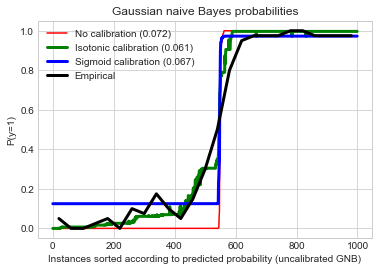

In [289]:
# Plot the predicted probabilities
plt.figure()
order = np.lexsort((prob_pos_clf, ))
plt.plot(prob_pos_clf[order], 'r', label='No calibration (%1.3f)' % clf_score)

plt.plot(prob_pos_isotonic[order], 'g', linewidth=3,
         label='Isotonic calibration (%1.3f)' % clf_isotonic_score)

plt.plot(prob_pos_sigmoid[order], 'b', linewidth=3,
         label='Sigmoid calibration (%1.3f)' % clf_sigmoid_score)

plt.plot(np.linspace(0, y_test.size, 51)[1::2], y_test[order].reshape(25, -1).mean(1),
         'k', linewidth=3, label=r'Empirical')

plt.ylim([-0.05, 1.05])
plt.xlabel("Instances sorted according to predicted probability "
           "(uncalibrated GNB)")
plt.ylabel("P(y=1)")
plt.legend(loc="upper left")
plt.title("Gaussian naive Bayes probabilities")

plt.show()

Below we continue using Naive Bayes caliberated with isotonic method. 

In [290]:
# We see isotonic calibration is performing best and below we run model evaluation on this version of Naive Bayes

y_pred_test = clf_sigmoid.predict(X_test)

#Print the time required to fit and evaluate the model
start_time = time.time()
print("Computational efforts: %s seconds ---" % (time.time() - start_time))

clf_isotonic_accuracy = accuracy_score(y_pred=y_pred_test, y_true=y_test)
clf_isotonic_precision = precision_score(y_pred=y_pred_test, y_true=y_test)
clf_isotonic_recall = recall_score(y_pred=y_pred_test, y_true=y_test)

print("Accuracy: {}. ".format(clf_isotonic_accuracy))
print("Precision: {}. ".format(clf_isotonic_precision))
print("Recall: {}. ".format(clf_isotonic_recall))

Computational efforts: 0.0 seconds ---
Accuracy: 0.928. 
Precision: 0.9579646017699115. 
Recall: 0.8909465020576132. 


Confusion matrix, without normalization
[[495  19]
 [ 53 433]]


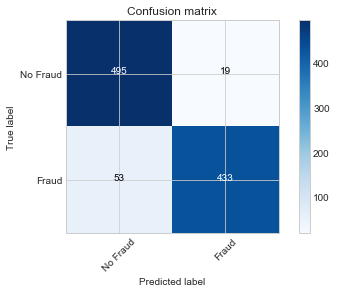

In [291]:
# Confusion matrix

cnf_matrix = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Confusion matrix')
plt.show()

So far, Naive Bayes performs worst among the models and because of the nature of this business the performance of this model is not acceptable.

## Model Training: KNeighbors 

In [292]:
# from sklearn import preprocessing, model_selection, neighbors
# from sklearn.metrics import confusion_matrix, average_precision_score

#Start the timer as a measure of the computing effort
start_time = time.time()

KNN = KNeighborsClassifier()  #initialize the KNN classifier

# Create range of values to fit parameters
neighbors = [3,5,7]
weight_sys = ['distance','uniform']
parameters = {'n_neighbors': neighbors, 'weights': weight_sys}

# Fit parameters using gridsearch
clf = GridSearchCV(KNN, param_grid=parameters, cv=CF_no)

#Fit the tunned model on the training set
clf.fit(train_x,train_y)

# Print the best hyperparameters set
print("Best Hyper Parameters:", clf.best_params_)

#Initialize the model on test dataset
clf.fit(test_x, test_y)

# Predict on test dataset
y_pred = clf.predict(test_x)

# Check the prediction power of the model
pred_y = np.array(clf.predict(test_x))
true_y = np.array(test_y)

#Print the time required to fit and evaluate the model
print("--- %s seconds ---" % round((time.time() - start_time)))

Best Hyper Parameters: {'n_neighbors': 3, 'weights': 'distance'}
--- 11 seconds ---


Confusion matrix, without normalization
[[514   0]
 [  0 486]]


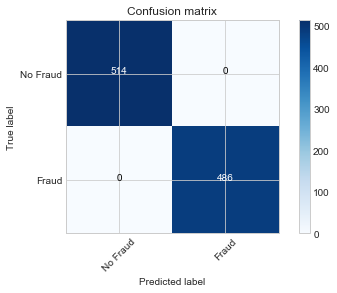

In [293]:
class_names = ['No Fraud', 'Fraud']
np.set_printoptions(precision=2)

cnf_matrix = confusion_matrix(true_y, pred_y)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Confusion matrix')
plt.show()

In [294]:
# Metrics computed from a confusion matrix
TP = cnf_matrix[1, 1]
TN = cnf_matrix[0, 0]
FP = cnf_matrix[0, 1]
FN = cnf_matrix[1, 0]

print("True Positives (TP): We correctly predicted the fraud: {}. ".format(TP))
print("True Negatives (TN): we correctly predicted that no fraud: {}. ".format(TN))
print("False Positives (FP): we incorrectly predicted that it is a fraud or Type I error: {}. ".format(FP))
print("False Negatives (FN): we incorrectly predicted that it is not a fraud or Type II error: {}. ".format(FN))

print("===================================================")

print("Overall, how often is the classifier correct (accuracy)? {}. ".format((TP + TN) / float(TP + TN + FP + FN)))      
print("Overall, how often is the classifier incorrect? {}. ".format((FP + FN) / float(TP + TN + FP + FN))) 
print("When the actual value is positive, how often is the prediction correct (sensitivity or recall)? {}.".format(TP / float(FN + TP))) 
print("When the actual value is negative, how often is the prediction correct (specificity)? {}.".format(TN / (TN + FP))) 
print("When the actual value is negative, how often is the prediction incorrect (false positive rate)? {}.".format(FP / float(TN + FP))) 
print("When a positive value is predicted, how often is the prediction correct (precision)? {}.".format(TP / float(TP + FP))) 

True Positives (TP): We correctly predicted the fraud: 486. 
True Negatives (TN): we correctly predicted that no fraud: 514. 
False Positives (FP): we incorrectly predicted that it is a fraud or Type I error: 0. 
False Negatives (FN): we incorrectly predicted that it is not a fraud or Type II error: 0. 
Overall, how often is the classifier correct (accuracy)? 1.0. 
Overall, how often is the classifier incorrect? 0.0. 
When the actual value is positive, how often is the prediction correct (sensitivity or recall)? 1.0.
When the actual value is negative, how often is the prediction correct (specificity)? 1.0.
When the actual value is negative, how often is the prediction incorrect (false positive rate)? 0.0.
When a positive value is predicted, how often is the prediction correct (precision)? 1.0.


In [295]:
# Which metrics should you focus on?
# This is the case of fraud detection therefore we should optimize for sensitivity or recall:
# FN is in this case more important as false positives (normal transactions that are marked as possible fraud
# are more acceptable than false negatives where actual fraud has happened and we fail to detect

## Model Training: Support Vector Machine

In [296]:
# Because of high cost of computation cost we do not tune the parameters here
# Otherwise here are the code in case we can afford it
## parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
## Fit parameters using gridsearch
## svc_tuned = GridSearchCV(svc, parameters, cv=CF_no)

#Start the timer as a measure of the computing effort
start_time = time.time()

# # Initialize and fit the model
svm = SVC(kernel = 'linear')
svm.fit(train_x, train_y)

# Predict on test dataset
y_pred = svm.predict(test_x)

# Check the prediction power of the model
pred_y = np.array(svm.predict(test_x))
true_y = np.array(test_y)

#Print the time required to fit and evaluate the model
print("--- %s seconds ---" % round((time.time() - start_time)))

--- 0 seconds ---


Confusion matrix, without normalization
[[507   7]
 [ 44 442]]


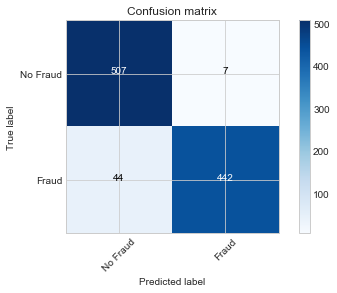

In [297]:
class_names = ['No Fraud', 'Fraud']
np.set_printoptions(precision=2)

cnf_matrix = confusion_matrix(true_y, pred_y)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Confusion matrix')
plt.show()

In [298]:
# Metrics computed from a confusion matrix
TP = cnf_matrix[1, 1]
TN = cnf_matrix[0, 0]
FP = cnf_matrix[0, 1]
FN = cnf_matrix[1, 0]

print("True Positives (TP): We correctly predicted the fraud: {}. ".format(TP))
print("True Negatives (TN): we correctly predicted that no fraud: {}. ".format(TN))
print("False Positives (FP): we incorrectly predicted that it is a fraud or Type I error: {}. ".format(FP))
print("False Negatives (FN): we incorrectly predicted that it is not a fraud or Type II error: {}. ".format(FN))

print("===================================================")

print("Overall, how often is the classifier correct (accuracy)? {}. ".format((TP + TN) / float(TP + TN + FP + FN)))      
print("Overall, how often is the classifier incorrect? {}. ".format((FP + FN) / float(TP + TN + FP + FN))) 
print("When the actual value is positive, how often is the prediction correct (sensitivity or recall)? {}.".format(TP / float(FN + TP))) 
print("When the actual value is negative, how often is the prediction correct (specificity)? {}.".format(TN / (TN + FP))) 
print("When the actual value is negative, how often is the prediction incorrect (false positive rate)? {}.".format(FP / float(TN + FP))) 
print("When a positive value is predicted, how often is the prediction correct (precision)? {}.".format(TP / float(TP + FP))) 

True Positives (TP): We correctly predicted the fraud: 442. 
True Negatives (TN): we correctly predicted that no fraud: 507. 
False Positives (FP): we incorrectly predicted that it is a fraud or Type I error: 7. 
False Negatives (FN): we incorrectly predicted that it is not a fraud or Type II error: 44. 
Overall, how often is the classifier correct (accuracy)? 0.949. 
Overall, how often is the classifier incorrect? 0.051. 
When the actual value is positive, how often is the prediction correct (sensitivity or recall)? 0.9094650205761317.
When the actual value is negative, how often is the prediction correct (specificity)? 0.9863813229571985.
When the actual value is negative, how often is the prediction incorrect (false positive rate)? 0.013618677042801557.
When a positive value is predicted, how often is the prediction correct (precision)? 0.9844097995545658.


## Model Training: Gradient Boost

In [299]:
# Here we collect the cross-validation average accuracy 
# for a number of estimators in the range (1, 20). 
# The loss function is the default one (multinomial negative log-likelihood):

Gradient_score_mean = []
max_estimators = 15
for i in range(1, max_estimators):
    score = cross_val_score(GradientBoostingClassifier(n_estimators=i, learning_rate=5.0/float(i)),
                            test_x, test_y, cv=10, scoring='accuracy').mean()
Gradient_score_mean.append(score)
print("Accuracy: {}".format(Gradient_score_mean))

Accuracy: [0.960947094709471]


In [300]:
# Start the timer as a measure of the computing effort
start_time = time.time()

# We'll make 20 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 20,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
Gradeboost = ensemble.GradientBoostingClassifier(**params)
Gradeboost.fit(train_x, train_y)

# Predict on test dataset
y_pred = clf.predict(test_x)

# Check the prediction power of the model
pred_y = np.array(clf.predict(test_x))
true_y = np.array(test_y)

#Print the time required to fit and evaluate the model
print("--- %s seconds ---" % round((time.time() - start_time)))

--- 0 seconds ---


Confusion matrix, without normalization
[[514   0]
 [  0 486]]


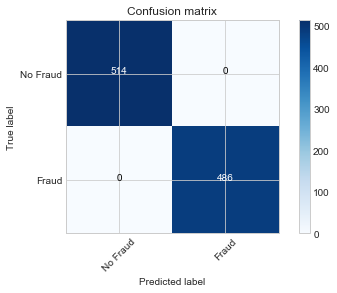

In [301]:
class_names = ['No Fraud', 'Fraud']
np.set_printoptions(precision=2)

cnf_matrix = confusion_matrix(true_y, pred_y)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Confusion matrix')
plt.show()

In [302]:
# Metrics computed from a confusion matrix
TP = cnf_matrix[1, 1]
TN = cnf_matrix[0, 0]
FP = cnf_matrix[0, 1]
FN = cnf_matrix[1, 0]

print("True Positives (TP): We correctly predicted the fraud: {}. ".format(TP))
print("True Negatives (TN): we correctly predicted that no fraud: {}. ".format(TN))
print("False Positives (FP): we incorrectly predicted that it is a fraud or Type I error: {}. ".format(FP))
print("False Negatives (FN): we incorrectly predicted that it is not a fraud or Type II error: {}. ".format(FN))

print("===================================================")

print("Overall, how often is the classifier correct (accuracy)? {}. ".format((TP + TN) / float(TP + TN + FP + FN)))      
print("Overall, how often is the classifier incorrect? {}. ".format((FP + FN) / float(TP + TN + FP + FN))) 
print("When the actual value is positive, how often is the prediction correct (sensitivity or recall)? {}.".format(TP / float(FN + TP))) 
print("When the actual value is negative, how often is the prediction correct (specificity)? {}.".format(TN / (TN + FP))) 
print("When the actual value is negative, how often is the prediction incorrect (false positive rate)? {}.".format(FP / float(TN + FP))) 
print("When a positive value is predicted, how often is the prediction correct (precision)? {}.".format(TP / float(TP + FP))) 

True Positives (TP): We correctly predicted the fraud: 486. 
True Negatives (TN): we correctly predicted that no fraud: 514. 
False Positives (FP): we incorrectly predicted that it is a fraud or Type I error: 0. 
False Negatives (FN): we incorrectly predicted that it is not a fraud or Type II error: 0. 
Overall, how often is the classifier correct (accuracy)? 1.0. 
Overall, how often is the classifier incorrect? 0.0. 
When the actual value is positive, how often is the prediction correct (sensitivity or recall)? 1.0.
When the actual value is negative, how often is the prediction correct (specificity)? 1.0.
When the actual value is negative, how often is the prediction incorrect (false positive rate)? 0.0.
When a positive value is predicted, how often is the prediction correct (precision)? 1.0.


## Conclusion 
In this analysis we lightly touched most of the phases of a typical ML life cycle. We started with data source then did some initial processing such as cleaning, format and quality check, transformation and feature selection.

We continued training some of the majors supervised ML models. Then did model evaluation using cross-validation and calculated some performance metrics for each model. We also optimized most of the hyperparameters. However, if we are aiming to develop ML for real life applications, then we need to strike a balance between ML optimization versus software application. At this stage we should avoid building "blackbox" and instead try to ensure our steps are extensible and modular. Pipeline versioning is one such method. 

The purpose of this ML work was to identify an algorithm that can learn from past transaction data. After learning then we produce a model that can be deployed to make intelligent recommendations for the nature of credit card transaction as being fraud or not.

Such fraud is a very rare event given the sheer size of credit card transactions. And fundamentally we like our model to focus on two main errors. One is false positive and the other is false negative. For false positive a transaction that matches the red flags identified in the fraud data profile but the transaction is not a fraudulent transaction. And the financial institution supporting such transactions may have audit procedures in place to address them. However, the more serious problem is the false negative where a transaction that does not match the red flags in the fraud data profile but the transaction is a fraudulent transaction. From a fraud data analytics perspective, false negatives occur due to not understanding the sophistication of concealment as it related to building your fraud data analytics plan. 

Because of the seriousness of false negative results, we here focus on selecting a model that has best sensitivity/recall as its performance metric.

For each of following models we show the percentage of time that the fraud prediction matches with an actual fraud situation:

- Logistic Regression (93%)
- Decision Tree (99%)
- Random Forest (93%)
- Naive - Bayes (Bernoulli) (89%)
- KNeighbors Classifier (100%)
- Support Vector Machine (91%)
- Gradient Boosting Classifier (100%)

From above, the Gradient Boosting and KNeighbors are the top 2 models with zero error of false negative.